In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import GCRCatalogs
import healpy
import pickle,sys
import mysql
from mysql.connector import Error
import clmm
from clmm.dataops import compute_galaxy_weights
from clmm import Cosmology
from scipy.integrate import simps
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
conn = mysql.connector.connect(host='ccqserv201', user='qsmaster', port=30040)
cursor = conn.cursor(dictionary=True, buffered=True)

In [2]:
sys.path.append('../lensing_profile_measurement')
import _utils_lensing_profiles

In [3]:
import _utils_photometric_redshifts
import _utils_extract_sources_in_cosmoDC2
import _config_lensing_profiles
from astropy.table import QTable, Table, vstack, join, hstack

## Cosmodc2 with qserv & GCRCatalogs

In [4]:
def qserv_query(ra, dec, rmax = 10):
    r"""
    quantities wanted + cuts
    Attributes:
    -----------
    z: float
        lens redshift
    ra: float
        lens right ascension
    dec: float
        lens declinaison
    rmax: float
        maximum radius
    """
    zmax = 3.
    zmin = 0
    theta_max = (rmax/lens_distance) * (180./np.pi)
    query = "SELECT data.coord_ra as ra, data.coord_dec as dec, data.redshift as z, "
    query += "data.galaxy_id as galaxy_id, "
    query += "data.mag_i, data.mag_r, data.mag_y, "
    query += "data.shear_1 as shear1, data.shear_2 as shear2, data.convergence as kappa, "
    query += "data.ellipticity_1_true as e1_true_uncorr, data.ellipticity_2_true as e2_true_uncorr " 
    query += "FROM cosmoDC2_v1_1_4_image.data as data "
    query += f"WHERE data.redshift >= {zmin} AND data.redshift < {zmax} "
    query += f"AND scisql_s2PtInCircle(coord_ra, coord_dec, {ra}, {dec}, {theta_max}) = 1 "
    query += f"AND data.mag_i <= 25 "
    query += ";" 
    return query

In [5]:
#cluster
path_to_data = '../../CLCosmo_Sim_database/data/'
lens_cat = np.load(path_to_data + 'lens_catalog_cosmoDC2_v1.1.4_redmapper_v0.8.1.pkl', allow_pickle = True)
mask = (lens_cat['richness'] > 20)&(lens_cat['redshift'] > .2)
index = 4000
z, ra, dec, richness = lens_cat['redshift'][mask][index], lens_cat['ra'][mask][index], lens_cat['dec'][mask][index], lens_cat['richness'][mask][index]

In [6]:
z, ra, dec, richness

(0.38360184, 72.62527257555823, -40.311777764790264, 21.239138)

### true shapes, true redshifts

In [7]:
lens_distance=cosmo.eval_da(z)
bckgd_galaxy_catalog_truth=_utils_extract_sources_in_cosmoDC2.extract(qserv_query = qserv_query( ra, dec, rmax = 6),
                                        conn_qserv=conn, cosmo=cosmo)

In [8]:
gc_bpz  = "cosmoDC2_v1.1.4_image_with_photozs_v1"
gc_flex = "cosmoDC2_v1.1.4_image_with_photozs_flexzboost_v1"
healpix_dc2 = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_image").get_catalog_info()['healpix_pixels']
z_bins  = GCRCatalogs.load_catalog(gc_flex).photoz_pdf_bin_centers
z_bins[0] = 1e-7
photoz_gc=[gc_bpz, gc_flex]
photoz_label=['_bpz', '_flex']

In [9]:
def query_photoz():
    return ['photoz_pdf', 'photoz_mean','photoz_mode','photoz_odds','galaxy_id']

In [10]:
#extract photometric redshifts with GCRCatalogs
print('extracting photoz redshift infos (GCRCatalogs)')
id_gal=bckgd_galaxy_catalog_truth['galaxy_id']
ras=bckgd_galaxy_catalog_truth['ra']
decs=bckgd_galaxy_catalog_truth['dec']
#find all different healpix pixels
healpix = np.array(np.unique(healpy.ang2pix(32, ras, decs, nest=False, lonlat=True)))
print(healpix)
table_photoz = Table()
table_photoz['galaxy_id'] = id_gal
for k, gc_ in enumerate(photoz_gc):
    print(f'----> extraction in {gc_}')
    pz_table = Table(names = ['sigmac_photoz', 'p_background', 'photoz_dispersion', 
                          'sigmac_estimate_0', 'sigmac_estimate_1', 'sigmac_estimate_2', 
                          'z_estimate_0', 'z_estimate_1', 'z_estimate_2', 
                          'galaxy_id', 'photoz_mean', 'photoz_mode', 'photoz_odds'])
    photoz_gc_ = GCRCatalogs.load_catalog(gc_)
    for i, hp in enumerate(healpix):
        #browse healpix pixels
        print(f'-----> heapix pixel = ' + str(hp))
        chunk = photoz_gc_.get_quantities(query_photoz(), native_filters=[f'healpix_pixel=={hp}'], return_iterator=True)
        print(chunk)
        for j in range(3):
            #browse chunk data
            print('chunk = ' + str(j))
            try: 
                dat_extract_photoz_chunk = Table(next(chunk))
            except: 
                print('no chunk')
                continue
            print(f'full healpix = ' + str(len(dat_extract_photoz_chunk['galaxy_id'])))
            #use only selected galaxies
            dat_extract_photoz_chunk_truncated = dat_extract_photoz_chunk[np.isin(dat_extract_photoz_chunk['galaxy_id'],
                                                                                  table_photoz['galaxy_id'])]
           # if len(dat_extract_photoz_chunk_truncated['galaxy_id']) == 0: continue

            print('truncated healpix = ' + str(len(dat_extract_photoz_chunk_truncated['galaxy_id'])))
            pzbins_table=np.array([z_bins for i in range(len(dat_extract_photoz_chunk_truncated['photoz_pdf'].data))])

            #compute WL weights with 
            pz_quantities_chunk = _utils_photometric_redshifts.compute_photoz_quantities(z, dat_extract_photoz_chunk_truncated['photoz_pdf'], 
                                                                   pzbins_table, n_samples_per_pdf=3, cosmo=cosmo,
                                                                   use_clmm=False)
            pz_quantities_chunk['galaxy_id'] = dat_extract_photoz_chunk_truncated['galaxy_id']
            pz_quantities_chunk['photoz_mean'] = dat_extract_photoz_chunk_truncated['photoz_mean']
            pz_quantities_chunk['photoz_mode'] = dat_extract_photoz_chunk_truncated['photoz_mode']
            pz_quantities_chunk['photoz_odds'] = dat_extract_photoz_chunk_truncated['photoz_odds']
            pz_table = vstack([pz_table, pz_quantities_chunk])
    colnames = pz_table.colnames
    for name in colnames:
        if name!='galaxy_id':
            pz_table.rename_column(name, name + photoz_label[k])
    bckgd_galaxy_catalog_truth = join(Table(bckgd_galaxy_catalog_truth), pz_table, keys='galaxy_id')

extracting photoz redshift infos (GCRCatalogs)
[10074]
----> extraction in cosmoDC2_v1.1.4_image_with_photozs_v1
-----> heapix pixel = 10074
<generator object BaseGenericCatalog._get_quantities_iter at 0x7f6c80fab6f0>
chunk = 0
full healpix = 832748
truncated healpix = 33713


/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


chunk = 1
full healpix = 600251
truncated healpix = 12658


/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


chunk = 2
full healpix = 138089
truncated healpix = 922


/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


----> extraction in cosmoDC2_v1.1.4_image_with_photozs_flexzboost_v1
-----> heapix pixel = 10074
<generator object BaseGenericCatalog._get_quantities_iter at 0x7f6c8186f060>
chunk = 0
full healpix = 832748
truncated healpix = 33713


/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


chunk = 1
full healpix = 600251
truncated healpix = 12658


/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


chunk = 2
full healpix = 138089
truncated healpix = 922


/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


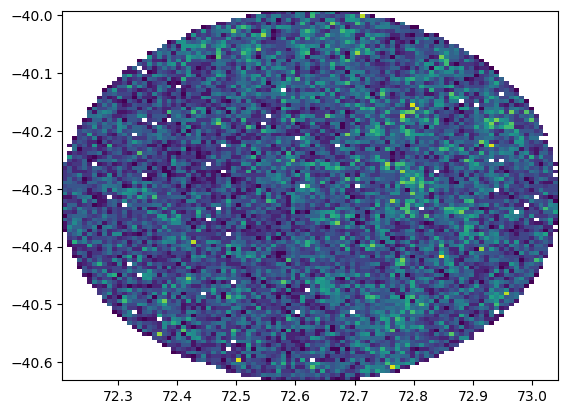

In [11]:
plt.hist2d(bckgd_galaxy_catalog_truth['ra'], bckgd_galaxy_catalog_truth['dec'], cmin=1, bins=100)
plt.show()

In [12]:
print(bckgd_galaxy_catalog_truth.colnames)

['ra', 'dec', 'z', 'galaxy_id', 'mag_i', 'mag_r', 'mag_y', 'shear1', 'shear2', 'kappa', 'e1_true_uncorr', 'e2_true_uncorr', 'g1', 'g2', 'e1_true', 'e2_true', 'e1', 'e2', 'sigmac_photoz_bpz', 'p_background_bpz', 'photoz_dispersion_bpz', 'sigmac_estimate_0_bpz', 'sigmac_estimate_1_bpz', 'sigmac_estimate_2_bpz', 'z_estimate_0_bpz', 'z_estimate_1_bpz', 'z_estimate_2_bpz', 'photoz_mean_bpz', 'photoz_mode_bpz', 'photoz_odds_bpz', 'sigmac_photoz_flex', 'p_background_flex', 'photoz_dispersion_flex', 'sigmac_estimate_0_flex', 'sigmac_estimate_1_flex', 'sigmac_estimate_2_flex', 'z_estimate_0_flex', 'z_estimate_1_flex', 'z_estimate_2_flex', 'photoz_mean_flex', 'photoz_mode_flex', 'photoz_odds_flex']


In [13]:
mask_mag= bckgd_galaxy_catalog_truth['mag_i'] < 24.5
mask_mag*= bckgd_galaxy_catalog_truth['mag_r'] < 28
bckgd_galaxy_catalog = bckgd_galaxy_catalog_truth[mask_mag]

In [14]:
ellipticity_uncorr_e1 = bckgd_galaxy_catalog['e1_true']
ellipticity_uncorr_e2 = bckgd_galaxy_catalog['e2_true']
ellipticity_corr_e1, ellipticity_corr_e2 = _utils_extract_sources_in_cosmoDC2.correct_shear_ellipticity(ellipticity_uncorr_e1, ellipticity_uncorr_e2)

In [15]:
ellipticity_corr_norm = (ellipticity_corr_e1**2+ellipticity_corr_e2**2)**.5
ellipticity_uncorr_norm = (ellipticity_uncorr_e1**2+ellipticity_uncorr_e2**2)**.5

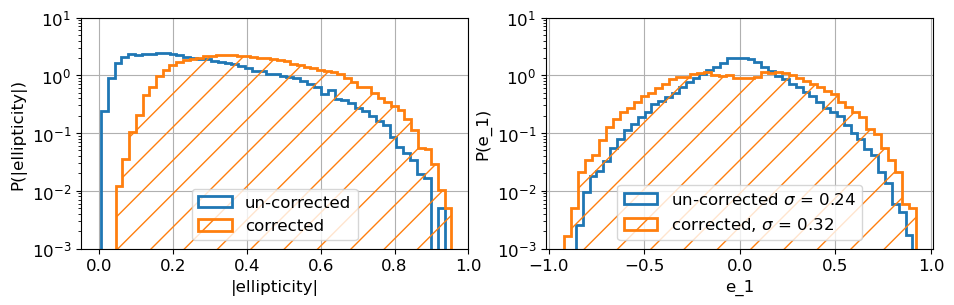

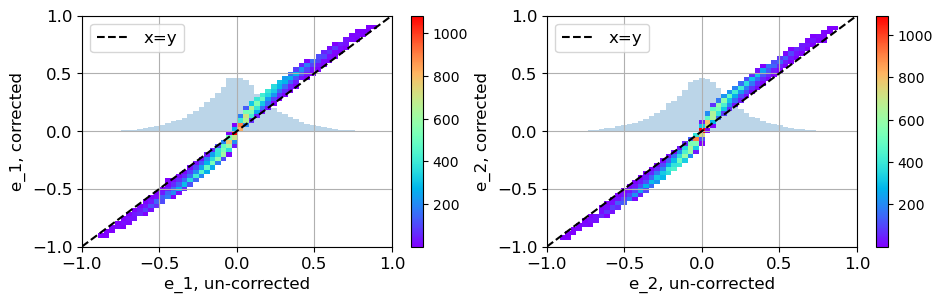

In [16]:
plt.figure(figsize=(11,3))
plt.subplot(121)
plt.grid(True)
plt.hist(ellipticity_uncorr_norm, bins=50,histtype = 'step',density=True, label = 'un-corrected', lw=2)
plt.hist(ellipticity_corr_norm, bins=50, histtype = 'step',density=True, label = 'corrected', lw=2, hatch='/')
plt.yscale('log')
plt.xlim(-.05, 1)
plt.ylim(1e-3, 10)
plt.xlabel('|ellipticity|', fontsize=12)
plt.ylabel('P(|ellipticity|)', fontsize=12)
plt.legend(fontsize=12)
plt.tick_params(axis='both', which = 'major', labelsize= 12)
plt.subplot(122)
plt.grid(True)
std1_uncorr = np.std(ellipticity_uncorr_e1)
std1_corr = np.std(ellipticity_corr_e1)
plt.hist(ellipticity_uncorr_e1, bins=50, histtype = 'step',density=True, label = f'un-corrected $\sigma$ = {std1_uncorr:.2f}', lw=2)
plt.hist(ellipticity_corr_e1, bins=50,histtype = 'step',density=True, label = f'corrected, $\sigma$ = {std1_corr:.2f}', lw=2, hatch='/')
plt.ylim(1e-3, 10)
plt.xlabel('e_1', fontsize=12)
plt.ylabel('P(e_1)', fontsize=12)
plt.legend(fontsize=12)
plt.tick_params(axis='both', which = 'major', labelsize= 12)
plt.yscale('log')
plt.savefig('../fig/ellipticity_correction_cosmoDC2.png', bbox_inches='tight', dpi=300)


plt.figure(figsize=(11,3))
plt.subplot(121)
plt.grid(True)
std1_uncorr = np.std(ellipticity_uncorr_e1)
std1_corr = np.std(ellipticity_corr_e1)
plt.hist2d(ellipticity_uncorr_e1, ellipticity_corr_e1, bins=50, cmin=1, cmap='rainbow')
plt.hist(ellipticity_uncorr_e1, bins=50, weights=(0*ellipticity_uncorr_e1+1)*.0002, zorder=0, alpha=.3)
plt.plot(np.linspace(-1, 1, 10), np.linspace(-1, 1, 10), '--k', label = 'x=y')
plt.xlabel('e_1, un-corrected', fontsize=12)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.ylabel('e_1, corrected', fontsize=12)
plt.legend(fontsize=12)
plt.tick_params(axis='both', which = 'major', labelsize= 12)
plt.colorbar()
plt.subplot(122)
plt.grid(True)
std1_uncorr = np.std(ellipticity_uncorr_e1)
std1_corr = np.std(ellipticity_corr_e1)
plt.hist2d(ellipticity_uncorr_e2, ellipticity_corr_e2, bins=50, cmin=1, cmap='rainbow')
plt.hist(ellipticity_uncorr_e2, bins=50, weights=(0*ellipticity_uncorr_e2+1)*.0002, zorder=0, alpha=.3)
plt.plot(np.linspace(-1, 1, 10), np.linspace(-1, 1, 10), '--k', label = 'x=y')
plt.xlabel('e_2, un-corrected', fontsize=12)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.ylabel('e_2, corrected', fontsize=12)
plt.legend(fontsize=12)
plt.colorbar()
plt.tick_params(axis='both', which = 'major', labelsize= 12)
plt.savefig('../fig/ellipticity_correction_cosmoDC2_corr_vs_uncorr.png', bbox_inches='tight', dpi=300)

In [17]:
theta_rad = 6/lens_distance
theta_arcmin = theta_rad * 3437.75
S_arcmin_2 = np.pi*theta_arcmin**2
S_deg_2 = np.pi*theta_arcmin**2
print(f'n_gal = {len(bckgd_galaxy_catalog)/S_deg_2:.1f} gal.armin^(-2)')

n_gal = 28.0 gal.armin^(-2)


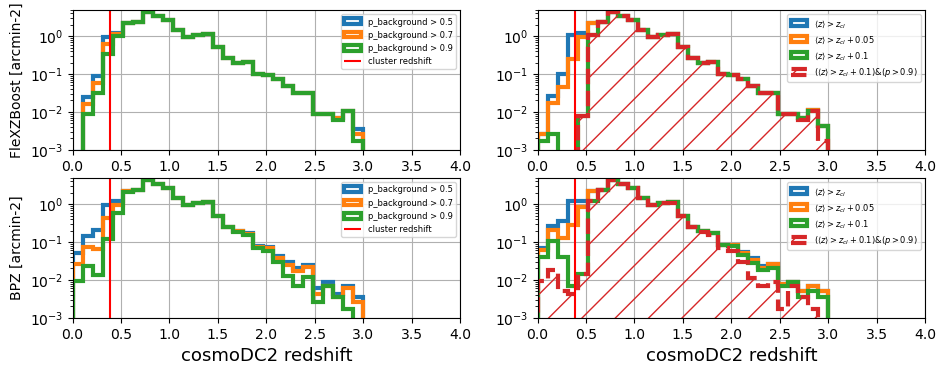

In [ ]:
photoz = 'flex'
plt.figure(figsize=(11,4))
plt.subplot(221)
bins_ = np.linspace(0, 3, 30)
mask_p1 = bckgd_galaxy_catalog[f'p_background_{photoz}'] > 0.5
plt.hist(bckgd_galaxy_catalog['z'][mask_p1], 
         weights=(0*bckgd_galaxy_catalog['z'][mask_p1] + 1)/S_arcmin_2,
         bins=bins_, histtype = 'step', lw=3, label = 'p_background > 0.5')
mask_p2 = bckgd_galaxy_catalog[f'p_background_{photoz}'] > 0.7
plt.hist(bckgd_galaxy_catalog['z'][mask_p2], 
         weights=(0*bckgd_galaxy_catalog['z'][mask_p2] + 1)/S_arcmin_2,
         bins=bins_, histtype = 'step', lw=3, label = 'p_background > 0.7')
mask_p3 = bckgd_galaxy_catalog[f'p_background_{photoz}'] > 0.9
plt.hist(bckgd_galaxy_catalog['z'][mask_p3], 
         weights=(0*bckgd_galaxy_catalog['z'][mask_p3] + 1)/S_arcmin_2,
         bins=bins_, histtype = 'step', lw=3, label = 'p_background > 0.9')
plt.vlines(z, 0, 10000, color='r', label = 'cluster redshift')
plt.ylim(1e-3, 5)
plt.xlim(0, 4)
plt.legend(loc='upper right', fontsize=6)
plt.yscale('log')
plt.grid(True)
plt.xlabel('cosmoDC2 redshift', fontsize=13)
plt.ylabel('FleXZBoost [arcmin-2]')
plt.subplot(222)

mask_z1 = bckgd_galaxy_catalog[f'photoz_mean_{photoz}'] > z
plt.hist(bckgd_galaxy_catalog['z'][mask_z1],
         weights=(0*bckgd_galaxy_catalog['z'][mask_z1] + 1)/S_arcmin_2,
         bins=bins_, histtype = 'step', lw=3, label = r'$\langle z \rangle > z_{cl}$')
mask_z2 = bckgd_galaxy_catalog[f'photoz_mean_{photoz}'] > z + .05
plt.hist(bckgd_galaxy_catalog['z'][mask_z2],
         weights=(0*bckgd_galaxy_catalog['z'][mask_z2] + 1)/S_arcmin_2,
          bins=bins_, histtype = 'step', lw=3, label = r'$\langle z \rangle > z_{cl} + 0.05$')
mask_z3 = bckgd_galaxy_catalog[f'photoz_mean_{photoz}'] > z + 0.2
plt.hist(bckgd_galaxy_catalog['z'][mask_z3],
         weights=(0*bckgd_galaxy_catalog['z'][mask_z3] + 1)/S_arcmin_2,
          bins=bins_, histtype = 'step', lw=3, label = r'$\langle z \rangle > z_{cl} + 0.1$')
A = plt.hist(bckgd_galaxy_catalog['z'][mask_z3*mask_p3],
         weights=(0*bckgd_galaxy_catalog['z'][mask_z3*mask_p3] + 1)/S_arcmin_2,
          bins=bins_, hatch='/', histtype = 'step', lw=3,ls='--', label = r'$(\langle z \rangle > z_{cl} + 0.1)&(p > 0.9)$')
plt.vlines(z, 0, 10000, color='r')
plt.ylim(1e-3, 5)
plt.xlim(0, 4)
plt.legend(loc='upper right', fontsize=6)
plt.yscale('log')
plt.grid(True)
plt.xlabel('cosmoDC2 redshift', fontsize=13)


photoz = 'bpz'
plt.subplot(223)
bins_ = np.linspace(0, 3, 30)
mask_p1 = bckgd_galaxy_catalog[f'p_background_{photoz}'] > 0.5
plt.hist(bckgd_galaxy_catalog['z'][mask_p1], 
         weights=(0*bckgd_galaxy_catalog['z'][mask_p1] + 1)/S_arcmin_2,
         bins=bins_, histtype = 'step', lw=3, label = 'p_background > 0.5')
mask_p2 = bckgd_galaxy_catalog[f'p_background_{photoz}'] > 0.7
plt.hist(bckgd_galaxy_catalog['z'][mask_p2], 
         weights=(0*bckgd_galaxy_catalog['z'][mask_p2] + 1)/S_arcmin_2,
         bins=bins_, histtype = 'step', lw=3, label = 'p_background > 0.7')
mask_p3 = bckgd_galaxy_catalog[f'p_background_{photoz}'] > 0.9
plt.hist(bckgd_galaxy_catalog['z'][mask_p3], 
         weights=(0*bckgd_galaxy_catalog['z'][mask_p3] + 1)/S_arcmin_2,
         bins=bins_, histtype = 'step', lw=3, label = 'p_background > 0.9')
plt.vlines(z, 0, 10000, color='r', label = 'cluster redshift')
plt.ylim(1e-3, 5)
plt.xlim(0, 4)
plt.legend(loc='upper right', fontsize=6)
plt.yscale('log')
plt.grid(True)
plt.xlabel('cosmoDC2 redshift', fontsize=13)
plt.ylabel('BPZ [arcmin-2]')
plt.subplot(224)

mask_z1 = bckgd_galaxy_catalog[f'photoz_mean_{photoz}'] > z
plt.hist(bckgd_galaxy_catalog['z'][mask_z1],
         weights=(0*bckgd_galaxy_catalog['z'][mask_z1] + 1)/S_arcmin_2,
         bins=bins_, histtype = 'step', lw=3, label = r'$\langle z \rangle > z_{cl}$')
mask_z2 = bckgd_galaxy_catalog[f'photoz_mean_{photoz}'] > z + .05
plt.hist(bckgd_galaxy_catalog['z'][mask_z2],
         weights=(0*bckgd_galaxy_catalog['z'][mask_z2] + 1)/S_arcmin_2,
          bins=bins_, histtype = 'step', lw=3, label = r'$\langle z \rangle > z_{cl} + 0.05$')
mask_z3 = bckgd_galaxy_catalog[f'photoz_mean_{photoz}'] > z + 0.2
plt.hist(bckgd_galaxy_catalog['z'][mask_z3],
         weights=(0*bckgd_galaxy_catalog['z'][mask_z3] + 1)/S_arcmin_2,
          bins=bins_, histtype = 'step', lw=3, label = r'$\langle z \rangle > z_{cl} + 0.1$')
A = plt.hist(bckgd_galaxy_catalog['z'][mask_z3*mask_p3],
         weights=(0*bckgd_galaxy_catalog['z'][mask_z3*mask_p3] + 1)/S_arcmin_2,
          bins=bins_, hatch='/', histtype = 'step', lw=3,ls='--', label = r'$(\langle z \rangle > z_{cl} + 0.1)&(p > 0.9)$')
plt.vlines(z, 0, 10000, color='r')
plt.ylim(1e-3, 5)
plt.xlim(0, 4)
plt.legend(loc='upper right', fontsize=6)
plt.yscale('log')
plt.grid(True)
plt.xlabel('cosmoDC2 redshift', fontsize=13)
plt.savefig(f'../fig/nz_source_selection_with_BPZ_FlexZBoost_for_z_cluster={z:.2f}.png', bbox_inches='tight', dpi=100)

In [19]:
cl = clmm.galaxycluster.GalaxyCluster('halo', ra, dec, z, clmm.gcdata.GCData(bckgd_galaxy_catalog))
theta, g_t, g_x = cl.compute_tangential_and_cross_components(is_deltasigma=False, cosmo=None)
R = lens_distance * theta
z_gal = bckgd_galaxy_catalog['z']

In [20]:
r_edges = np.linspace(0, 6, 10)
r_bins = [[r_edges[i], r_edges[i+1]] for i in range(len(r_edges)-1)]

In [21]:
def contamination(R, mask_pz):
    R_mask_pz = R[mask_pz]
    z_mask_pz = z_gal[mask_pz]
    c, cerr = [], []
    for i, r_bin in enumerate(r_bins):
        mask_r = (R_mask_pz <= r_bin[1])*(R_mask_pz >= r_bin[0])
        R_mask_pz_in_r = R_mask_pz[mask_r]
        z_mask_pz_in_r = z_mask_pz[mask_r]
        z_foreground_in_r = z_mask_pz_in_r[z_mask_pz_in_r < z]
        c.append(len(z_foreground_in_r)/len(z_mask_pz_in_r))
        cerr.append(np.sqrt(len(z_foreground_in_r)*(len(z_mask_pz_in_r)-len(z_foreground_in_r))/len(z_mask_pz_in_r)**3))
    return np.array(c), np.array(cerr)

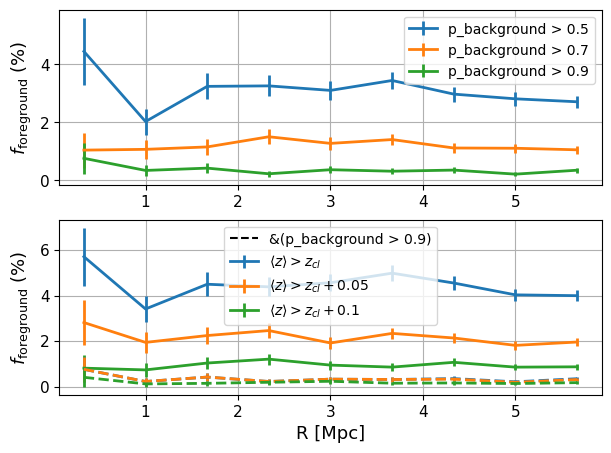

In [ ]:
plt.figure(figsize=(7,5))
plt.subplot(2, 1, 1)
plt.errorbar(np.mean(r_bins, axis=1), 100*contamination(R, mask_p1)[0], 
             100*contamination(R, mask_p1)[1], color='C0', label = 'p_background > 0.5',  lw=2,)
plt.errorbar(np.mean(r_bins, axis=1), 100*contamination(R, mask_p2)[0],
             100*contamination(R, mask_p2)[1], color='C1', label = 'p_background > 0.7',  lw=2,)
plt.errorbar(np.mean(r_bins, axis=1), 100*contamination(R, mask_p3)[0], 
         100*contamination(R, mask_p3)[1], color='C2', label = 'p_background > 0.9',  lw=2,)
plt.legend()
plt.grid(True)
plt.ylabel(r'$f_{\rm foreground}$ (%)', fontsize=13)
plt.tick_params(axis='both', which = 'both', labelsize= 11)
#plt.ylim(0, 10)
plt.subplot(2, 1, 2)
plt.errorbar(np.mean(r_bins, axis=1), 100*contamination(R, mask_z1)[0],
             100*contamination(R, mask_z1)[1], fmt='-', label = r'$\langle z \rangle > z_{cl}$',  lw=2,)
plt.errorbar(np.mean(r_bins, axis=1), 100*contamination(R, mask_z2)[0],
             100*contamination(R, mask_z2)[1], fmt='-', label = r'$\langle z \rangle > z_{cl} + 0.05$',  lw=2,)
plt.errorbar(np.mean(r_bins, axis=1), 100*contamination(R, mask_z3)[0], 
            100*contamination(R, mask_z3)[1], fmt='-', label = r'$\langle z \rangle > z_{cl} + 0.1$',  lw=2,)
plt.subplot(2, 1, 2)
plt.errorbar(np.mean(r_bins, axis=1), 100*contamination(R, mask_z1&mask_p3)[0],
             100*contamination(R, mask_z1&mask_p3)[1], fmt='--', color='C0',  lw=2,)
plt.errorbar(np.mean(r_bins, axis=1), 100*contamination(R, mask_z2&mask_p3)[0], 
             100*contamination(R, mask_z2&mask_p3)[1], fmt='--', color='C1',  lw=2,)
plt.errorbar(np.mean(r_bins, axis=1), 100*contamination(R, mask_z3&mask_p3)[0], 
             100*contamination(R, mask_z3&mask_p3)[1], fmt='--', color='C2',  lw=2,)
plt.plot([], [], '--k', label = '&(p_background > 0.9)')
plt.legend()
plt.grid(True)
#plt.ylim(0, 10)
plt.ylabel(r'$f_{\rm foreground}$ (%)', fontsize=13)
plt.xlabel('R [Mpc]', fontsize=13)
#plt.ylim(0,20)
plt.tick_params(axis='both', which = 'both', labelsize= 11)
plt.savefig(f'../fig/contamination_member_and_foreground_galaxies_with_{photoz}_for_z_cluster={z:.2f}.png', bbox_inches='tight', dpi=100)